# Importing Libraries 

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

# Loading & Discovering The Data

In [5]:
data = pd.read_csv('/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv')
data.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [6]:
data.isnull().sum()

Index                        0
message to examine           0
label (depression result)    0
dtype: int64

In [7]:
data = data.rename(columns={'message to examine': 'tweet'})
data = data.rename(columns={'label (depression result)': 'label'})

In [8]:
data = data.drop(['Index'],axis=1)

Class Distribution:
label
0    8000
1    2314
Name: count, dtype: int64


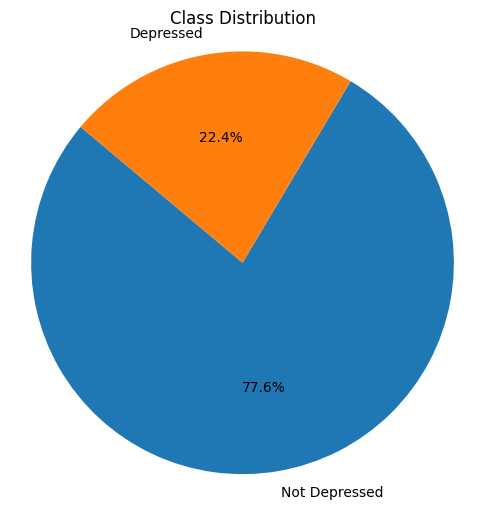

In [9]:
class_distribution = data['label'].value_counts()
print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=['Not Depressed', 'Depressed'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# Data Cleaning & Preprocessing 

In [10]:
import re

def preprocess_tweet(tweet):
    
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r'#', '', tweet)

    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    
    tweet = tweet.lower()
    
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = re.sub(r'\n+', '\n', tweet)
    
    if not re.search('[a-zA-Z]', tweet):
        tweet = None
    
    return tweet

data['tweet'] = data['tweet'].apply(preprocess_tweet)

In [11]:
data.head()

,tweet,label
0,just had a real good moment i miss him so much,0
1,is reading manga,0
2,None,0
3,need to send em to my accountant tomorrow odd...,0
4,add me on myspace myspacecomlookthunder,0


In [12]:
data.isnull().sum()

tweet    27
label     0
dtype: int64

In [13]:
data.dropna(inplace = True)
data.isnull().sum()

tweet    0
label    0
dtype: int64

In [14]:
data.shape

(10287, 2)

# Data Tokenization 

In [15]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

data['tokens'] = data['tweet'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Splitting 

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tokens'], data['label'], test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42)  # 0.1/0.9 = 0.1111

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 8229
Validation set size: 1029
Test set size: 1029


# Data Transformation 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train= tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in X_train])

X_val = tfidf_vectorizer.transform([' '.join(tokens) for tokens in X_val])
X_test = tfidf_vectorizer.transform([' '.join(tokens) for tokens in X_test])


# Ensemble Learning Approach 

In [18]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
catboost_classifier = CatBoostClassifier(random_state=42, verbose=0)

ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_classifier),
    ('xgb', xgb_classifier),
    ('catboost', catboost_classifier)
], voting='soft')

ensemble_model.fit(X_train, y_train)

val_accuracy = ensemble_model.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9922254616132167


In [19]:
test_accuracy = ensemble_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.989310009718173


# Transfer Learning using Pre-trained Model 

## Checking The avilabilty of the GPU

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Splitting

In [39]:
X = data['tweet']
y = data['label']


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/9, random_state=42)


## Import The Bert Model 

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels: depressed or not
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Tokenization 

In [42]:
train_tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in X_train]
val_tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in X_val]
test_tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, max_length=128, truncation=True) for text in X_test]

## Padding

In [43]:
max_len = max(len(tokens) for tokens in train_tokenized_texts + val_tokenized_texts + test_tokenized_texts)
train_padded_tokenized_texts = [tokens + [0]*(max_len-len(tokens)) for tokens in train_tokenized_texts]
val_padded_tokenized_texts = [tokens + [0]*(max_len-len(tokens)) for tokens in val_tokenized_texts]
test_padded_tokenized_texts = [tokens + [0]*(max_len-len(tokens)) for tokens in test_tokenized_texts]

## Convert To Tensors

In [44]:
train_input_ids = torch.tensor(train_padded_tokenized_texts).to(device)
val_input_ids = torch.tensor(val_padded_tokenized_texts).to(device)
test_input_ids = torch.tensor(test_padded_tokenized_texts).to(device)

train_labels = torch.tensor(y_train.values).to(device)
val_labels = torch.tensor(y_val.values).to(device)
test_labels = torch.tensor(y_test.values).to(device)

## Data Loader

In [45]:
train_dataset = TensorDataset(train_input_ids, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(val_input_ids, val_labels)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [46]:
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Model Training

In [47]:
model.train()
for epoch in range(3):  # Adjust number of epochs as needed
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for batch in train_loader:
        batch_input_ids, batch_labels = batch
        batch_input_ids, batch_labels = batch_input_ids.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        predictions = torch.argmax(outputs.logits, axis=1)
        correct = (predictions == batch_labels).sum().item()
        total_correct += correct
        total_samples += batch_labels.size(0)
        
        loss.backward()
        optimizer.step()
    
    # Compute training accuracy
    train_accuracy = total_correct / total_samples
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        
        for val_batch in val_loader:
            val_batch_input_ids, val_batch_labels = val_batch
            val_batch_input_ids, val_batch_labels = val_batch_input_ids.to(device), val_batch_labels.to(device)
            val_outputs = model(input_ids=val_batch_input_ids, labels=val_batch_labels)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()
            
            val_predictions = torch.argmax(val_outputs.logits, axis=1)
            val_correct = (val_predictions == val_batch_labels).sum().item()
            total_val_correct += val_correct
            total_val_samples += val_batch_labels.size(0)
    
    val_accuracy = total_val_correct / total_val_samples
    
    print(f"Epoch {epoch+1}/{3}, Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")




Epoch 1/3, Train Loss: 0.0733, Train Accuracy: 0.9753, Validation Accuracy: 0.9981
Epoch 2/3, Train Loss: 0.0024, Train Accuracy: 0.9998, Validation Accuracy: 0.9981
Epoch 3/3, Train Loss: 0.0024, Train Accuracy: 0.9998, Validation Accuracy: 0.9981


## Model Evaluation 

In [48]:
model.eval()
with torch.no_grad():
    outputs = model(input_ids=test_input_ids, labels=test_labels)
    predictions = torch.argmax(outputs.logits, axis=1)
    test_accuracy = accuracy_score(test_labels.cpu().numpy(), predictions.cpu().numpy())
    print("Test Accuracy (BERT):", test_accuracy)

Test Accuracy (BERT): 0.9990281827016521
